In [1]:
from headers import *
# %matplotlib notebook

Defining a Class for DMPs

In [114]:
class DMP():
	
	def __init__(self,timesteps=100):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = 1*self.alphaz/3    
        
		self.time_steps = timesteps
		self.tau = self.time_steps

		self.dimensions = 3
		self.number_kernels = max(self.time_steps,1000)
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
		self.rollout_time = max(self.time_steps,200)
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))                
		self.goal = npy.zeros(self.dimensions)
		self.start = npy.zeros(self.dimensions)  
		self.initial_velocity = npy.zeros(self.dimensions)

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase        

# 		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]       
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]*2))**2        
		dummy = (npy.diff(self.gaussian_kernels[:,0]*0.55))**2            
		self.gaussian_kernels[:,1] = 1. / npy.append(dummy,dummy[-1])

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)
    
	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
        
		for k in range(self.dimensions):
			self.eta[:,k] = vector_phase*(self.demo_pos[-1,k]-self.demo_pos[0,k])

	def learn_DMP(self):	
		self.update_target_force_itau()        
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP() 
        
	def initialize_rollout(self,start,goal,init_vel):
		self.tau = self.rollout_time        
		self.pos_roll[0] = copy.deepcopy(start)        
		self.vel_roll[0] = copy.deepcopy(init_vel)
		self.goal = goal
		self.start = start
		self.dt = self.tau/self.rollout_time        
		print(self.dt)

	def calc_rollout_force(self,roll_time):
		den = 0        
# 		time = float(roll_time)/self.rollout_time 
		time = copy.deepcopy(roll_time)        
		for i in range(self.number_kernels):
			self.force_roll[roll_time] += self.basis(i,time)*self.weights[i]
			den += self.basis(i,time)
		self.force_roll[roll_time] *= (self.goal-self.start)*self.calc_phase(time)/den
            
	def calc_rollout_acceleration(self,time):        
# 		self.acc_roll[time] = (1/self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_roll[time-1]) - self.tau*self.vel_roll[time-1]) + self.force_roll[time])
		self.acc_roll[time] = (1./self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_roll[time]) - self.tau*self.vel_roll[time]) + self.force_roll[time])    
        
	def calc_rollout_vel(self,time):
# 		self.vel_roll[time] = self.vel_roll[time-1] + self.acc_roll[time]*self.dt
# 		self.vel_roll[time] = self.vel_roll[time-1] + self.acc_roll[time-1]*self.dt
		self.vel_roll[time] = self.vel_roll[time-1] + self.acc_roll[time-1]*self.dt

	def calc_rollout_pos(self,time):
# 		self.pos_roll[time] = self.pos_roll[time-1] + self.vel_roll[time]*self.dt
		self.pos_roll[time] = self.pos_roll[time-1] + self.vel_roll[time-1]*self.dt
# 		self.pos_roll[time+1] = self.pos_roll[time] + self.vel_roll[time]*self.dt    
    
	def rollout(self,start,goal,init_vel):

		self.initialize_rollout(start,goal,init_vel)        
		self.calc_rollout_force(0)
		self.calc_rollout_acceleration(0)  
		for i in range(1,self.rollout_time):        
			self.calc_rollout_force(i)     
			self.calc_rollout_vel(i)                     
			self.calc_rollout_pos(i)                                
			self.calc_rollout_acceleration(i) 

In [115]:
# cd ../../Data/Cornell_Data/Primitive_Library/Subject1/Traj_18/

In [116]:
i1 = 13
i2 = 300
dmp = DMP(i2-i1)	

pos = npy.load("left_hand_pos_18.npy")[i1:i2,:3]
vel = npy.load("left_hand_vel_18.npy")[i1:i2,:3]
acc = npy.load("left_hand_acc_18.npy")[i1:i2,:3]

# pos = npy.load("right_hand_pos_18.npy")[i1:i2,:3]
# vel = npy.load("right_hand_vel_18.npy")[i1:i2,:3]
# acc = npy.load("right_hand_acc_18.npy")[i1:i2,:3]

dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
dmp.learn_DMP()

In [117]:
# b = npy.zeros((dmp.number_kernels,dmp.time_steps))
# tr = range(dmp.time_steps)

# dmp.tau = dmp.time_steps
# # dmp.gaussian_kern
# # for i in range(dmp.number_kernels):
# #     for t in range(dmp.time_steps):
# #         b[i,t]=dmp.basis(i,t)        
# #     plt.plot(tr,b[i])    
# k=100

# fig,ax = plt.subplots()
# for i in range(9):
#     for t in range(dmp.time_steps):
#         b[i,t]=dmp.basis(i*100,t)        
#     ax.plot(tr,b[i])    
    
# plt.show()
# # dmp.tau =100 
# b.shape

In [118]:
# force = npy.zeros((dmp.time_steps,dmp.dimensions))
# dmp.goal = copy.deepcopy(dmp.demo_pos[-1])

# for t in range(dmp.time_steps):
#     den = 0
#     for i in range(dmp.number_kernels):
#         force[t] += dmp.weights[i]*dmp.basis(i,t)
#         den += dmp.basis(i,t)   
#     for k in range(dmp.dimensions):
#         force[t,k]*=(dmp.goal[k]-dmp.demo_pos[0,k])*dmp.calc_phase(t)/den

# tr = range(0,dmp.time_steps)
# fig,ax= plt.subplots()
# ax.plot(tr,force,'r',label='Reconstructed Forces',linewidth=3)
# ax.plot(tr,dmp.target_forces,'b',label='Target Forces')
# ax.set_title("Target Forces and Reconstructed Values")
# plt.tight_layout()
# plt.show()

In [119]:
normalized_demo = copy.deepcopy(dmp.demo_pos)
normalization_vector = dmp.demo_pos[-1]-dmp.demo_pos[0]
normalized_demo -= normalized_demo[0]
normalized_demo /= normalized_demo[-1]

normalized_initial_velocity = npy.diff(normalized_demo,axis=0)[0]
# normalized_initial_velocity = npy.divide(dmp.demo_vel[0],normalization_vector)
normalized_initial_velocity

array([-0.01395349,  0.03643411,  0.00167785])

In [120]:
start = npy.zeros(dmp.dimensions)
goal = npy.ones(dmp.dimensions)
# dmp.rollout(dmp.demo_pos[0],dmp.demo_pos[-1])
dmp.rollout(start, goal,normalized_initial_velocity)
# dmp.rollout(start,goal,npy.zeros(3))

1


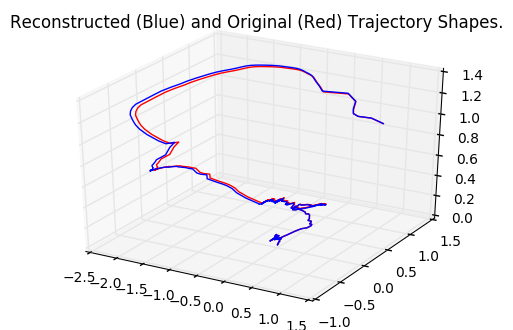

In [121]:
fig = plt.figure()
ax = fig.gca(projection='3d')

np = copy.deepcopy(dmp.demo_pos)
np -= np[0]
np /= np[-1]
ax.plot(np[:,0],np[:,1],np[:,2],'r')
# dmp.pos_roll += dmp.pos_roll[0]
ax.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1],dmp.pos_roll[:,2],'b')

# ind = [178,233,407]
# ind = [290,250,340]
# ind = npy.linspace(0,90,11).astype(int)
# ax.scatter(dmp.pos_roll[ind,0],dmp.pos_roll[ind,1],dmp.pos_roll[ind,2],'r',s=50)
# ax.scatter(np[ind,0],np[ind,1],np[ind,2],'b',s=50)
ax.set_title("Reconstructed (Blue) and Original (Red) Trajectory Shapes.")
# plt.savefig("Reconstructed_Trajectory_{0}.png".format(st),bbox_inches='tight')
plt.show()

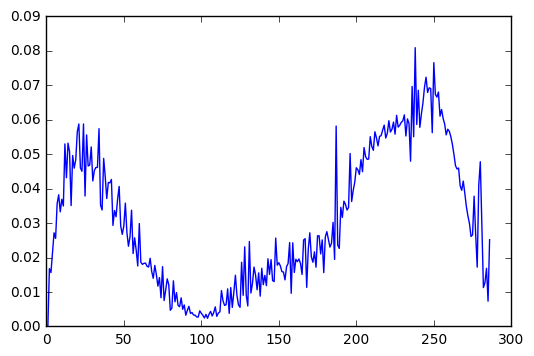

In [113]:
fig,ax=plt.subplots()
ax.plot(range(dmp.time_steps),npy.linalg.norm(np-dmp.pos_roll,axis=1))
plt.show()

In [170]:
force_norm = npy.linalg.norm(dmp.force_roll,axis=1)
normalized_forces = copy.deepcopy(dmp.force_roll)
# normalized_forces = dmp.force_roll/force_norm
for k in range(dmp.dimensions):
    normalized_forces[:,k] /= force_norm
force_dot_prod = npy.zeros(dmp.rollout_time-1)
for i in range(dmp.rollout_time-1):
    force_dot_prod[i] = npy.dot(normalized_forces[i],normalized_forces[i+1])

In [172]:
from mpltools import style
style.use('dark_background')

fig,ax = plt.subplots()
ax.plot(range(dmp.rollout_time-1),force_dot_prod,'r')
# plt.scatter(sort[1:-1],force_dot_prod[sort[1:-1]])
# inds = [62,100,144,198,236,312,360,400,462]
# plt.plot(inds,force_dot_prod[inds],'or')

plt.show()

ImportError: No module named mpltools

In [223]:
args = npy.argsort(force_dot_prod)[0:10]
# npy.sort(args)

In [246]:
lh_args = npy.argsort(force_dot_prod)[0:30]
lh_args

array([247, 413, 325, 107, 333, 387, 411, 242, 246, 188, 439, 357, 170,
       218, 267, 326, 249, 321,  48, 343,   3, 324, 248, 382,  12, 338,
       367, 483, 335, 158])

In [175]:
sort = npy.sort(args)
sort[9] = 400

In [224]:
npy.sort(lh_args)

array([ 13,  23,  35,  38,  41,  67, 111, 129, 137, 143, 148, 152, 163,
       177, 179, 186, 189, 216, 236, 326, 350, 354, 378, 383, 384, 388,
       401, 406, 487, 492])

In [177]:
sort = npy.append(0,sort)

In [178]:
sort

array([  0,  89, 121, 239, 253, 289, 295, 341, 363, 371, 400])

In [180]:
interval_score = npy.zeros(10)
for i in range(10):
    interval_score[i] = force_dot_prod[sort[i]:sort[i+1]].sum()

In [181]:
interval_score

array([-18.3350072 , -10.31602361, -12.29622109,  -5.18610533,
         0.16098385,  -0.635144  ,  -1.41067721,  -5.30444525,
        -4.53587642,   9.16122008])

In [191]:
nis = interval_score/npy.max(abs(interval_score))
nis

array([-1.        , -0.56264083, -0.67064174, -0.28285265,  0.00878014,
       -0.03464106, -0.076939  , -0.28930696, -0.24738885,  0.49965729])

In [187]:
sort[0:-1]

array([  0,  89, 121, 239, 253, 289, 295, 341, 363, 371])

<IPython.core.display.Javascript object>


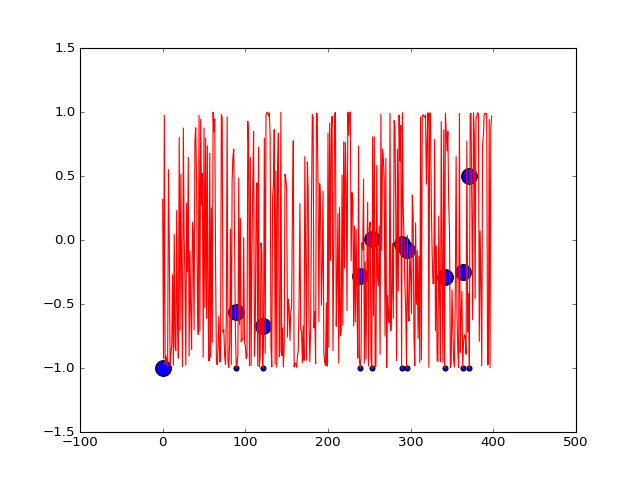

In [196]:
plt.plot(range(dmp.rollout_time-1),force_dot_prod,'r')
plt.scatter(sort[1:-1],force_dot_prod[sort[1:-1]])
plt.scatter(sort[0:-1],nis,s=200)
plt.show()

In [134]:
plt.plot(range(dmp.time_steps),npy.linalg.norm(dmp.demo_vel,axis=1))
plt.show()

In [54]:
dmp.demo_vel

array([[ -2.4,   4.7,  -1.2],
       [ -0.5,  -1. ,  -2.1],
       [ -1.2,   2.7,  -1.3],
       [ -0.8,   1.5,   0.7],
       [ -2.1,   1.2,  -0.1],
       [ -0.1,   3. ,   1.3],
       [ -0.9,   0. ,  -0.1],
       [ -3.9,   2.5,  -1.7],
       [ -0.5,   5.6,   0.9],
       [ -1.7,   1.8,  -0.4],
       [ -2.2,  -0.6,   0.9],
       [ -3.9,  -6.7,  -1.7],
       [ -2.3,   1.5,   2. ],
       [ -3.4,  -0.3,   0.6],
       [ -1. ,   5.8,   1.7],
       [ -4.3,   8.1,  -0.3],
       [ -3.2,  -2.9,  -3.5],
       [  1.1,  -1.8,   0.2],
       [  1.5,  -4.8,  -0.5],
       [  1.6,  -6.1,  -1.9],
       [  3.6,  -0.6,  -2.1],
       [ -2.7,   5.3,  -2. ],
       [ -0.9,   1.8,  -3. ],
       [ -0.3,  -2.7,  -3.5],
       [  0.4,   4.6,  -4.8],
       [  3.2,  -5.4,  -3.1],
       [  4.8,  -0.2,  -2.5],
       [  3.5,  -2.8,  -5. ],
       [  3.8,  -4.5,  -3.2],
       [  4.1,  -1.2,  -4.1],
       [  3.1,  -6. ,  -5.5],
       [  3.7,  -7.3,  -5.4],
       [  1.6,  -7.7,  -4.9],
       [  

In [64]:
dmp.vel_roll

array([[ -1.39534884e-02,   3.64341085e-02,   1.67785235e-03],
       [ -6.28585868e-03,   8.66537699e-03,   2.37772325e-03],
       [  8.29034535e-03,  -3.64219667e-02,   2.09994718e-03],
       [  2.49987646e-02,  -8.22007741e-02,   5.48636813e-04],
       [  3.57178978e-02,  -1.04063566e-01,  -2.01406555e-03],
       [  3.18728597e-02,  -7.91699225e-02,  -4.65550835e-03],
       [  8.89642359e-03,   3.10517958e-04,  -5.97365435e-03],
       [ -2.94516950e-02,   1.16070652e-01,  -4.64572681e-03],
       [ -6.93236692e-02,   2.21679651e-01,  -1.84609433e-04],
       [ -8.97091994e-02,   2.54999610e-01,   6.41379341e-03],
       [ -7.05985265e-02,   1.64831867e-01,   1.25345414e-02],
       [ -4.33381089e-03,  -5.62064594e-02,   1.46268846e-02],
       [  9.45730039e-02,  -3.47625338e-01,   9.70941910e-03],
       [  1.87202237e-01,  -5.82954676e-01,  -2.74639036e-03],
       [  2.20253245e-01,  -6.08423998e-01,  -1.94067237e-02],
       [  1.48485973e-01,  -3.14194023e-01,  -3.3124099

In [448]:
dmp.acc_roll/5000

array([[  1.61100506e-01,  -7.23927341e-01,   1.29241752e-03],
       [ -5.37700353e-02,   3.20989611e-01,  -2.94564858e-02],
       [ -3.68165297e-02,   2.72373231e-03,  -4.85984768e-02],
       [ -9.81889693e-02,   3.33586285e-02,  -3.65539517e-03],
       [  1.06335451e-01,   1.74149603e-01,  -2.27586793e-02],
       [ -1.13721642e-01,  -1.89108518e-01,   2.74263556e-02],
       [ -2.31034969e-01,   3.33432128e-01,   2.56230433e-02],
       [  1.89909023e-01,   3.59963279e-01,  -4.14751785e-02],
       [ -6.57650754e-02,  -3.75088197e-01,   8.14229869e-03],
       [ -1.12143900e-01,  -4.80064836e-01,  -9.12367880e-03],
       [ -1.36330116e-01,  -5.02669532e-01,   3.01309508e-02],
       [  6.83678741e-02,   7.44146847e-01,  -5.53570002e-02],
       [ -2.87869731e-02,   1.83421943e-01,   7.70843438e-03],
       [  1.06546611e-01,   7.05108696e-01,  -5.24931568e-03],
       [ -2.12188600e-01,   1.56156871e-01,   4.99098551e-02],
       [  1.00396018e-01,  -1.07766590e+00,   5.6693376

In [437]:
# norm_vel = copy.deepcopy(dmp.demo_vel)/normalization_vector
# norm_vel

# # SAME AS:npy.diff(normalized_demo,axis=0)

In [445]:
norm_acc = npy.diff(normalized_demo,axis=0,n=2)
norm_acc

array([[  1.10465116e-02,  -4.41860465e-02,   1.25838926e-03],
       [ -4.06976744e-03,   2.86821705e-02,  -1.11856823e-03],
       [  2.32558140e-03,  -9.30232558e-03,  -2.79642058e-03],
       [ -7.55813953e-03,  -2.32558140e-03,   1.11856823e-03],
       [  1.16279070e-02,   1.39534884e-02,  -1.95749441e-03],
       [ -4.65116279e-03,  -2.32558140e-02,   1.95749441e-03],
       [ -1.74418605e-02,   1.93798450e-02,   2.23713647e-03],
       [  1.97674419e-02,   2.40310078e-02,  -3.63534676e-03],
       [ -6.97674419e-03,  -2.94573643e-02,   1.81767338e-03],
       [ -2.90697674e-03,  -1.86046512e-02,  -1.81767338e-03],
       [ -9.88372093e-03,  -4.72868217e-02,   3.63534676e-03],
       [  9.30232558e-03,   6.35658915e-02,  -5.17337808e-03],
       [ -6.39534884e-03,  -1.39534884e-02,   1.95749441e-03],
       [  1.39534884e-02,   4.72868217e-02,  -1.53803132e-03],
       [ -1.91860465e-02,   1.78294574e-02,   2.79642058e-03],
       [  6.39534884e-03,  -8.52713178e-02,   4.4742729